## Import Data

In [ ]:
import gzip
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn
from collections import Counter

: 

In [ ]:
DATA_PATH = os.path.join("data", "processed", "phoenixweather2014t")

try:
    with gzip.open(os.path.join(DATA_PATH, 'phoenix14t.pami0.train.annotations_only.gzip'), "rb") as f:
        annotations = pickle.load(f)
except:
    print("Error: Invalid path")

### Convert to Pandas DataFrame

In [ ]:
VIDEO_PATH = os.path.join(DATA_PATH, "videos_phoenix", "videos")
names = list(
    map(
        lambda x: os.path.join(*x.split("/")) + ".mp4",
        [key["name"] for key in annotations],
    )
)
glosses = [key["gloss"] for key in annotations]
texts = [key["text"] for key in annotations]

data = {"paths": names, "glosses": glosses, "texts": texts}

df = pd.DataFrame(data)


Preprocessing

In [ ]:
# Removing duplicate rows
df = df.drop_duplicates()

# Removing rows with missing information
df = df.dropna()

# Make text lowercase and glosses uppercase
df["texts"] = df["texts"].str.lower()
df["glosses"] = df["glosses"].str.upper()

# Removing periods
df["texts"] = df["texts"].str.replace(".", "")
df["texts"] = df["texts"].str.strip()

# Removing sequences with plus in it
df = df.loc[~df["glosses"].str.contains(r'[\+]+')]

# Removing numbers
df["texts"] = df["texts"].str.replace(r"\d+", "")
df["glosses"] = df["glosses"].str.replace(r"\d+", "")

# Removing invalid video paths
df = df.loc[df["paths"].astype(str).map(lambda file: os.path.exists(os.path.join(VIDEO_PATH, file)))]

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.describe()

# Univariate Analysis

Creating lists with length of glosses sequences, length of German sentences, and number of frames respectively.

In [24]:
def with_opencv(filename):
    video = cv2.VideoCapture(filename)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

    return frame_count

gloss_lengths = list(map(lambda x: len(x.split()), list(df['glosses'])))
text_lengths = list(map(lambda x: len(x.split()), list(df['texts'])))
frames = list(map(lambda x: with_opencv(x), list([os.path.join(VIDEO_PATH, path) for path in list(df['paths'])])))

Descriptive statistics about each list

In [25]:
gloss_df = pd.DataFrame(gloss_lengths).rename(columns={0: 'Gloss Lengths'})
text_df = pd.DataFrame(text_lengths).rename(columns={0: 'Text Lengths'})
frame_df = pd.DataFrame(frames).rename(columns={0: 'Frames'})

display(gloss_df.describe(include='all'))
display(text_df.describe(include='all'))
display(frame_df.describe(include='all'))

,Gloss Lengths
count,7048.000000
mean,7.763763
std,3.419277
min,1.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,30.000000


,Text Lengths
count,7048.000000
mean,13.933598
std,5.969471
min,1.000000
25%,10.000000
50%,13.000000
75%,17.000000
max,52.000000


,Frames
count,7048.000000
mean,116.313138
std,49.707845
min,16.000000
25%,83.000000
50%,111.000000
75%,144.000000
max,475.000000


Histogram

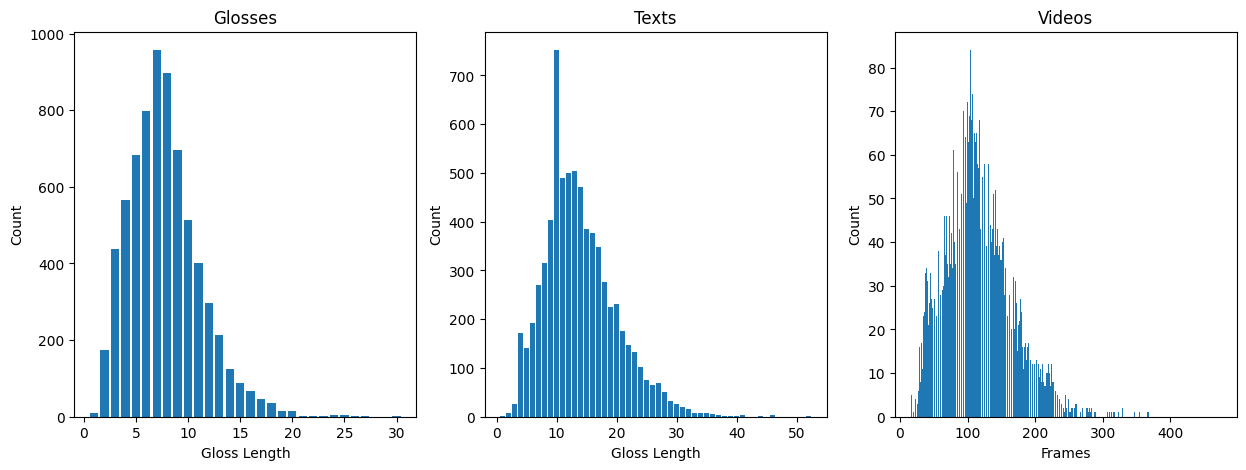

In [26]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

gloss_count = Counter(gloss_lengths)
text_count = Counter(text_lengths)
frame_count = Counter(frames)

axis[0].bar(gloss_count.keys(), gloss_count.values())
axis[0].set_title('Glosses')
axis[0].set_xlabel("Gloss Length")
axis[0].set_ylabel("Count")

axis[1].bar(text_count.keys(), text_count.values())
axis[1].set_title('Texts')
axis[1].set_xlabel("Gloss Length")
axis[1].set_ylabel("Count")

axis[2].bar(frame_count.keys(), frame_count.values())
axis[2].set_title('Videos')
axis[2].set_xlabel("Frames")
axis[2].set_ylabel("Count")
plt.show()

Boxplot

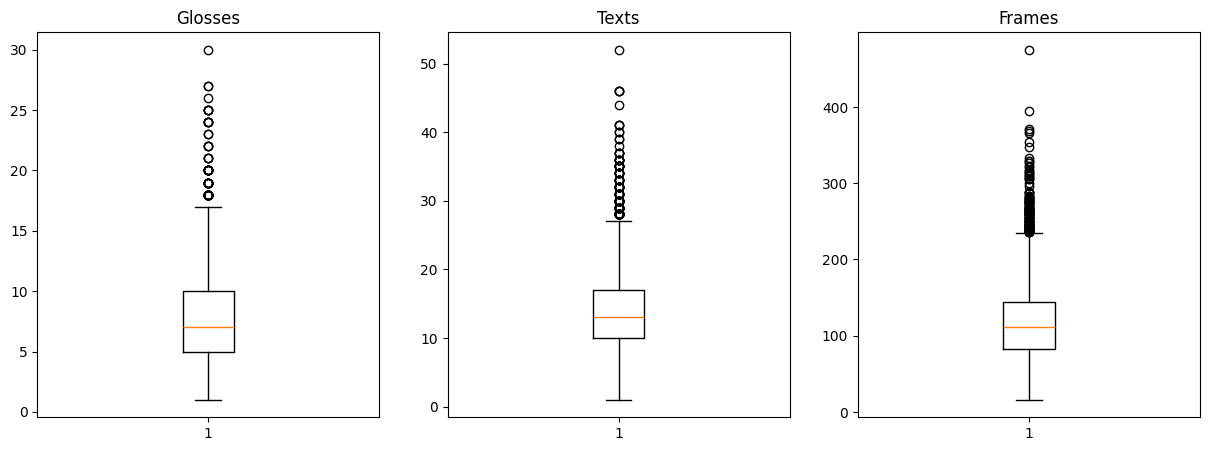

In [27]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

axis[0].boxplot(gloss_lengths)
axis[0].set_title("Glosses")

axis[1].boxplot(text_lengths)
axis[1].set_title("Texts")

axis[2].boxplot(frames)
axis[2].set_title("Frames")

plt.show()

# Multivariate Analysis

In [28]:
m_df = pd.DataFrame({'gloss_length': gloss_lengths, 'sentence_length': text_lengths, 'frames': frames})

Correlation Matrix

<Axes: >

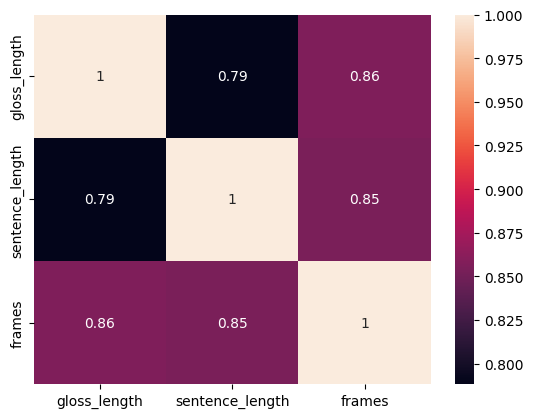

In [29]:
corr = m_df.corr()
seaborn.heatmap(corr, annot=True)

Pair Plot

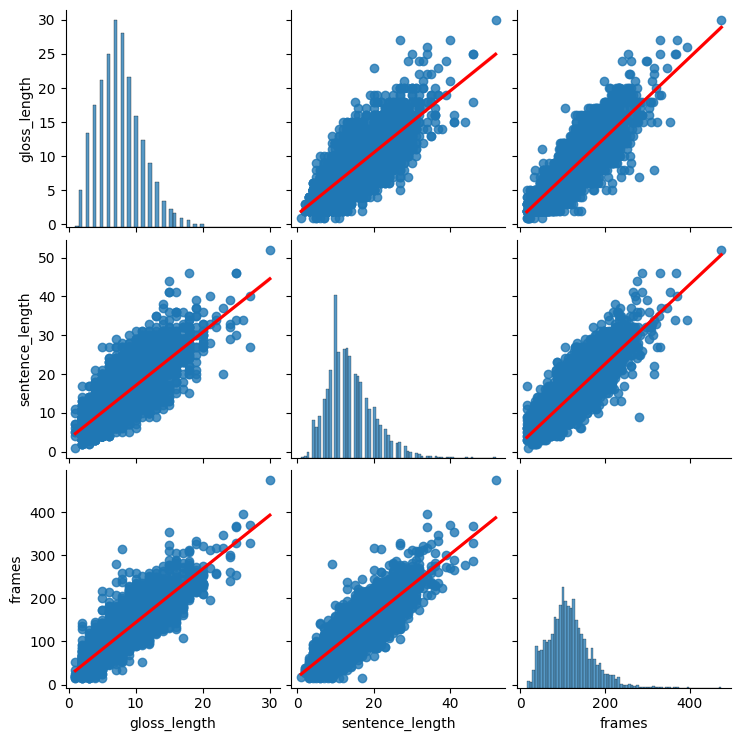

In [30]:
seaborn.pairplot(m_df, kind='reg',  plot_kws={'line_kws':{'color':'red'}})
plt.show()

# Token Univariate Analysis

<Axes: >

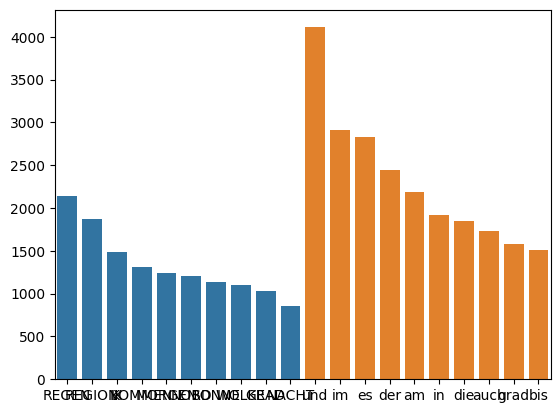

In [ ]:
import itertools

gloss_count = Counter(itertools.chain.from_iterable([sequence.split() for sequence in df['glosses']]))
word_count = Counter(itertools.chain.from_iterable([sequence.split() for sequence in df['texts']]))

glosses, gloss_total = zip(*gloss_count.most_common(10))
words, word_total = zip(*word_count.most_common(10))

seaborn.barplot(x=glosses, y=gloss_total)
seaborn.barplot(x=words, y=word_total)